# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [ ]:
data = pd.read_csv('/content/IHSG_market_clustered.csv')
data.head()

,timestamp,code,Name,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector,Cluster
0,2022-06-02,AKKU,Anugerah Kagum Karya Utama Tbk,2720.0,2740.0,2660.0,2680.0,-1.470588,-1.831502,80.0,Consumer Cyclicals,Stable-Positive
1,2022-06-09,ABMM,ABM Investama Tbk.,276.0,282.0,274.0,278.0,0.724638,0.724638,8.0,Industrials,Downward-Trend
2,2022-06-10,ABMM,ABM Investama Tbk.,980.0,1000.0,970.0,985.0,0.510204,2.604167,30.0,Industrials,Stable-Positive
3,2022-06-24,ABMM,ABM Investama Tbk.,860.0,885.0,850.0,850.0,-1.162791,-1.162791,35.0,Industrials,Stable-Positive
4,2022-06-27,ABMM,ABM Investama Tbk.,765.0,815.0,750.0,775.0,1.307190,-3.726708,65.0,Industrials,Downward-Trend


In [ ]:
# Menghapus columns yang tidak relevan

df = data.drop(columns=['timestamp', 'code', 'Name'])
df.head()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector,Cluster
0,2720.0,2740.0,2660.0,2680.0,-1.470588,-1.831502,80.0,Consumer Cyclicals,Stable-Positive
1,276.0,282.0,274.0,278.0,0.724638,0.724638,8.0,Industrials,Downward-Trend
2,980.0,1000.0,970.0,985.0,0.510204,2.604167,30.0,Industrials,Stable-Positive
3,860.0,885.0,850.0,850.0,-1.162791,-1.162791,35.0,Industrials,Stable-Positive
4,765.0,815.0,750.0,775.0,1.307190,-3.726708,65.0,Industrials,Downward-Trend


In [ ]:
df.dropna(inplace=True)
df.isna().sum()

,0
open,0
high,0
low,0
close,0
DifPriceCurrentage,0
DifPricePreviousage,0
Volatile,0
Sector,0
Cluster,0


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [ ]:
# memisahkan feature dan label
X = df.drop('Cluster', axis=1)
y = df['Cluster']

**Melakukan preprocessing data Standarisasi dan Encoding**

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

num_feature = X.select_dtypes(include=['int64', 'float64']).columns
cat_feature = X.select_dtypes(include=['object']).columns

# Standarization
pt = StandardScaler()
X[num_feature] = pt.fit_transform(X[num_feature])

# Label Encoding
le = LabelEncoder()
for col in cat_feature:
    X[col] = le.fit_transform(X[col])

X.head()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector
0,3.641105,3.630332,3.594972,3.579746,-0.613526,-0.940195,3.424961,1
1,-0.575887,-0.573688,-0.568198,-0.570545,0.574374,0.534796,-0.538161,6
2,0.638828,0.654337,0.646206,0.651043,0.458338,1.619357,0.672793,6
3,0.431774,0.457648,0.436826,0.417784,-0.446968,-0.554323,0.948009,6
4,0.267857,0.337924,0.262342,0.288195,0.889609,-2.033802,2.599310,6


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# mengetahui jumlah bais pada data latih dan data uji
print("Jumlah data: ", len(X))
print("Jumlah data latih: ", len(X_train))
print("Jumlah data uji: ", len(X_test))

Jumlah data:  23359
Jumlah data latih:  18687
Jumlah data uji:  4672


In [ ]:
# Ukuran label data latih
y_train.value_counts()

,count
Cluster,
Stable-Positive,7765
Downward-Trend,5649
Mildloss-ModerateVolatile,3534
High-Volatility,1739


In [ ]:
# Ukuran label data test
y_test.value_counts()

,count
Cluster,
Stable-Positive,1918
Downward-Trend,1428
Mildloss-ModerateVolatile,891
High-Volatility,435


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [ ]:
knn = KNeighborsClassifier().fit(X_train, y_train)
dt = DecisionTreeClassifier().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

print("Model training selesai.")

Model training selesai.


Pada pemodelan kali ini menggunakan semua algoritma yang tersedia agar dapat membandingkan semua model pada kasus klasikasi multikelas

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [ ]:
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))

                           precision    recall  f1-score   support

           Downward-Trend       0.34      0.38      0.36      1428
          High-Volatility       0.40      0.36      0.38       435
Mildloss-ModerateVolatile       0.43      0.40      0.41       891
          Stable-Positive       0.47      0.45      0.46      1918

                 accuracy                           0.41      4672
                macro avg       0.41      0.40      0.40      4672
             weighted avg       0.42      0.41      0.41      4672



Text(70.72222222222221, 0.5, 'Actual')

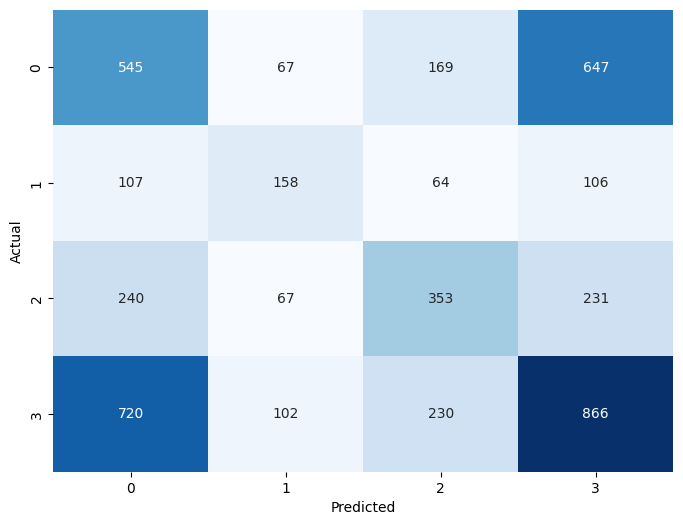

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
y_pred_dt = dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))

                           precision    recall  f1-score   support

           Downward-Trend       0.38      0.39      0.38      1428
          High-Volatility       0.45      0.45      0.45       435
Mildloss-ModerateVolatile       0.48      0.47      0.48       891
          Stable-Positive       0.48      0.48      0.48      1918

                 accuracy                           0.45      4672
                macro avg       0.45      0.45      0.45      4672
             weighted avg       0.45      0.45      0.45      4672



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

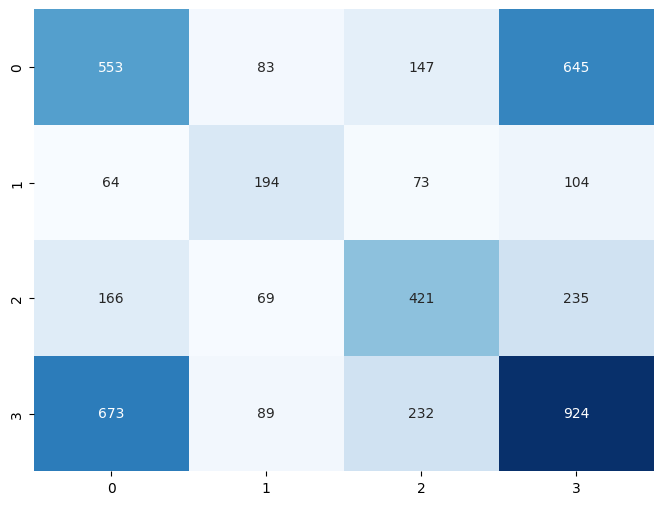

In [ ]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt

In [ ]:
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

                           precision    recall  f1-score   support

           Downward-Trend       0.38      0.33      0.35      1428
          High-Volatility       0.57      0.44      0.50       435
Mildloss-ModerateVolatile       0.56      0.47      0.51       891
          Stable-Positive       0.48      0.58      0.53      1918

                 accuracy                           0.47      4672
                macro avg       0.50      0.46      0.47      4672
             weighted avg       0.47      0.47      0.47      4672



<Axes: >

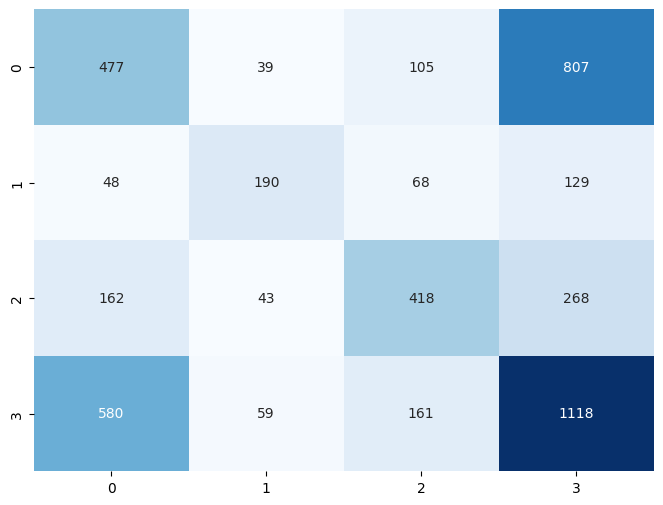

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

### **KNN**

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import time

param_dist_knn = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
random_search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist_knn,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=11)

start_time = time.time()
random_search_knn.fit(X_train, y_train)

print("Best Parameters: ", random_search_knn.best_params_)
print(f"Best Score: {random_search_knn.best_score_:.2f}")
print("Execution time: ", time.time() - start_time)

Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Best Score: 0.45
Execution time:  23.410748958587646


### **Decision Tree**

In [24]:
param_dist_dt = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}


dt = DecisionTreeClassifier()
random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist_dt,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=11)

start_time = time.time()
random_search_dt.fit(X_train, y_train)

print("Best Parameters: ", random_search_dt.best_params_)
print(f"Best Score: {random_search_dt.best_score_:.2f}")
print("Execution time: ", time.time() - start_time)

Best Parameters:  {'criterion': 'gini', 'max_depth': 16, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 14}
Best Score: 0.46
Execution time:  8.273469924926758


### **Random Forest**

In [25]:
param_dist_rf = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=11)

start_time = time.time()
random_search_rf.fit(X_train, y_train)

print("Best Parameters: ", random_search_rf.best_params_)
print(f"Best Score: {random_search_rf.best_score_:.2f}")
print("Execution time: ", time.time() - start_time)

Best Parameters:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 19, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 106}
Best Score: 0.49
Execution time:  427.2418785095215


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

### **KNN**

In [31]:
knn_tuned = KNeighborsClassifier(
    n_neighbors=19,
    weights='distance',
    metric='manhattan')
knn_tuned.fit(X_train, y_train)
y_pred_knn_tuned = knn_tuned.predict(X_test)

print("KNN Before Tuning\n")
print(classification_report(y_test, y_pred_knn))
print("\nKNN After Tuning\n")
print(classification_report(y_test, y_pred_knn_tuned))

KNN Before Tuning

                           precision    recall  f1-score   support

           Downward-Trend       0.34      0.38      0.36      1428
          High-Volatility       0.40      0.36      0.38       435
Mildloss-ModerateVolatile       0.43      0.40      0.41       891
          Stable-Positive       0.47      0.45      0.46      1918

                 accuracy                           0.41      4672
                macro avg       0.41      0.40      0.40      4672
             weighted avg       0.42      0.41      0.41      4672


KNN After Tuning

                           precision    recall  f1-score   support

           Downward-Trend       0.35      0.29      0.32      1428
          High-Volatility       0.52      0.37      0.43       435
Mildloss-ModerateVolatile       0.49      0.41      0.45       891
          Stable-Positive       0.46      0.58      0.51      1918

                 accuracy                           0.44      4672
                mac

### **Decision Tree**

In [32]:
dt_tuned = DecisionTreeClassifier(
    criterion='gini',
    max_depth=16,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=14,
    random_state=42)
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

print("Decision Tree Before Tuning\n")
print(classification_report(y_test, y_pred_dt))
print("\nDecision Tree After Tuning\n")
print(classification_report(y_test, y_pred_dt_tuned))

Decision Tree Before Tuning

                           precision    recall  f1-score   support

           Downward-Trend       0.38      0.39      0.38      1428
          High-Volatility       0.45      0.45      0.45       435
Mildloss-ModerateVolatile       0.48      0.47      0.48       891
          Stable-Positive       0.48      0.48      0.48      1918

                 accuracy                           0.45      4672
                macro avg       0.45      0.45      0.45      4672
             weighted avg       0.45      0.45      0.45      4672


Decision Tree After Tuning

                           precision    recall  f1-score   support

           Downward-Trend       0.38      0.31      0.34      1428
          High-Volatility       0.52      0.49      0.51       435
Mildloss-ModerateVolatile       0.51      0.48      0.49       891
          Stable-Positive       0.49      0.57      0.53      1918

                 accuracy                           0.47      4672

### **Random Forest**

In [33]:
rf_tuned = RandomForestClassifier(
    bootstrap=False,
    criterion='entropy',
    max_depth=17,
    max_features='log2',
    min_samples_leaf=14,
    min_samples_split=14,
    n_estimators=171,
    random_state=42
)

rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)

print("Random Forest Before Tuning\n")
print(classification_report(y_test, y_pred_rf))
print("\nRandom Forest After Tuning\n")
print(classification_report(y_test, y_pred_rf_tuned))

Random Forest Before Tuning

                           precision    recall  f1-score   support

           Downward-Trend       0.38      0.33      0.35      1428
          High-Volatility       0.57      0.44      0.50       435
Mildloss-ModerateVolatile       0.56      0.47      0.51       891
          Stable-Positive       0.48      0.58      0.53      1918

                 accuracy                           0.47      4672
                macro avg       0.50      0.46      0.47      4672
             weighted avg       0.47      0.47      0.47      4672


Random Forest After Tuning

                           precision    recall  f1-score   support

           Downward-Trend       0.39      0.22      0.28      1428
          High-Volatility       0.62      0.43      0.51       435
Mildloss-ModerateVolatile       0.56      0.49      0.52       891
          Stable-Positive       0.48      0.70      0.57      1918

                 accuracy                           0.49      4672

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah analisis hasil evaluasi setelah Hyperparameter Tuning
1. Secara umum semua metrik pada Confusion Metrics menunjukkan peningkatan setelah Hyperparameter Tuning, namun pada kelas Downward_Trend metrik recall mengalami penurunan pada semua model setelah Hyperparameter tuning
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall tergolong rendah pada kelas Downward-Trend dibanding kelas lain
  - Semua model masih belum mampu menangkap pola dalam model dengan indikasi accuracy masih <50%
3. Model yang paling optimal yang dapat digunakan ialah model Random Forest dengan accuracy yang mendekati 50%. Namun, terdapat beberapa masukan yang diberikan diantaranya melakukan feature_selection berdasarkan importance nya untuk mengurangi fitur yang saling berkorelasi secara signifikan